In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. LOAD DATA
df = pd.read_csv('Mental Health dataset1.csv')

target_column = 'Treatment'

# Removed Country & SocialWeakness.1
predictor_columns = [
    'Gender', 'Occupation', 'SelfEmployed', 'FamilyHistory',
    'DaysIndoors', 'HabitsChange', 'MentalHealthHistory', 'IncreasingStress',
    'MoodSwings', 'SocialWeakness', 'CopingStruggles', 'WorkInterest',
    'MentalHealthInterview', 'CareOptions'
]

final_predictors = [col for col in predictor_columns if col in df.columns]

X = df[final_predictors]
y = df[target_column]



In [60]:
#  PREPROCESS (Encode Yes/No)
y = y.replace({0: "No", 1: "Yes"})
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 0 = No, 1 = Yes

X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)
X_encoded = X_encoded.fillna(0)

In [61]:
#  TRAIN / TEST SPLIT Logistic Regression

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
model.fit(X_train, y_train)


# TRAIN MULTINOMIAL NAIVE BAYES
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)

MultinomialNB()

In [62]:
# MODEL PERFORMANCE

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["No", "Yes"])

print(" Logistic Regression Model Performance ")
print(f"Model Accuracy: {accuracy:.4f}")
print("All The Report(Precision, recall f1, support):")
print(report)

# MULTINOMIAL NAIVE BAYES PERFORMANCE
mnb_y_pred = mnb_model.predict(X_test)
mnb_accuracy = accuracy_score(y_test, mnb_y_pred)
mnb_report = classification_report(y_test, mnb_y_pred, target_names=["No", "Yes"])

print(" MULTINOMIAL NAIVE BAYES MODEL PERFORMANCE ")
print(f"Model Accuracy: {mnb_accuracy:.4f}")
print("All The Report(Precision, recall f1, support):")
print(mnb_report)

 Logistic Regression Model Performance 
Model Accuracy: 0.7596
All The Report(Precision, recall f1, support):
              precision    recall  f1-score   support

          No       0.63      0.55      0.59      1097
         Yes       0.81      0.85      0.83      2439

    accuracy                           0.76      3536
   macro avg       0.72      0.70      0.71      3536
weighted avg       0.75      0.76      0.76      3536

 MULTINOMIAL NAIVE BAYES MODEL PERFORMANCE 
Model Accuracy: 0.7407
All The Report(Precision, recall f1, support):
              precision    recall  f1-score   support

          No       0.66      0.33      0.44      1097
         Yes       0.75      0.92      0.83      2439

    accuracy                           0.74      3536
   macro avg       0.71      0.63      0.64      3536
weighted avg       0.73      0.74      0.71      3536



In [63]:
# ERROR RATES (FPR & FNR)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("Error Rates")
print(f"False Positive Rate (FPR): {fpr_mnb:.4f}")
print(f"False Negative Rate (FNR): {fnr_mnb:.4f}")

Error Rates
False Positive Rate (FPR): 0.6682
False Negative Rate (FNR): 0.0754


In [64]:
# MULTINOMIAL ERROR RATES
cm_mnb = confusion_matrix(y_test, mnb_y_pred)

tn_mnb, fp_mnb, fn_mnb, tp_mnb = cm_mnb.ravel()

fpr_mnb = fp_mnb / (fp_mnb + tn_mnb)
fnr_mnb = fn_mnb / (fn_mnb + tp_mnb)
print("Error Rates")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

Error Rates
False Positive Rate (FPR): 0.4458
False Negative Rate (FNR): 0.1480


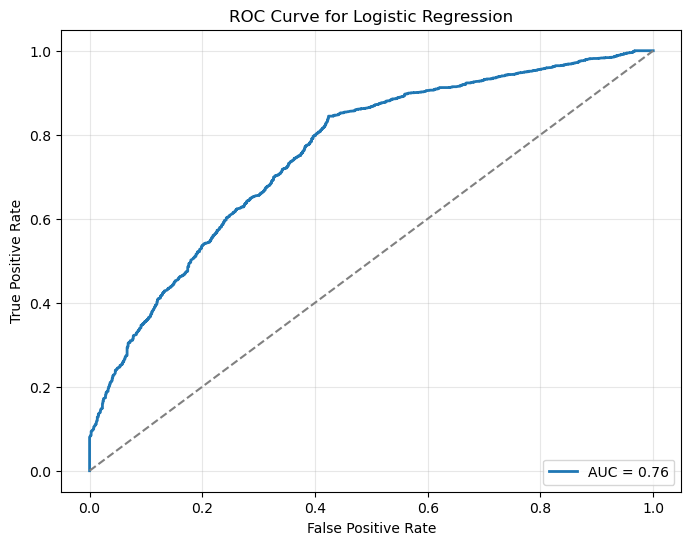

In [65]:
# ROC CURVE
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr_curve, tpr_curve, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr_curve, tpr_curve)

plt.figure(figsize=(8, 6))
plt.plot(fpr_curve, tpr_curve, linewidth=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

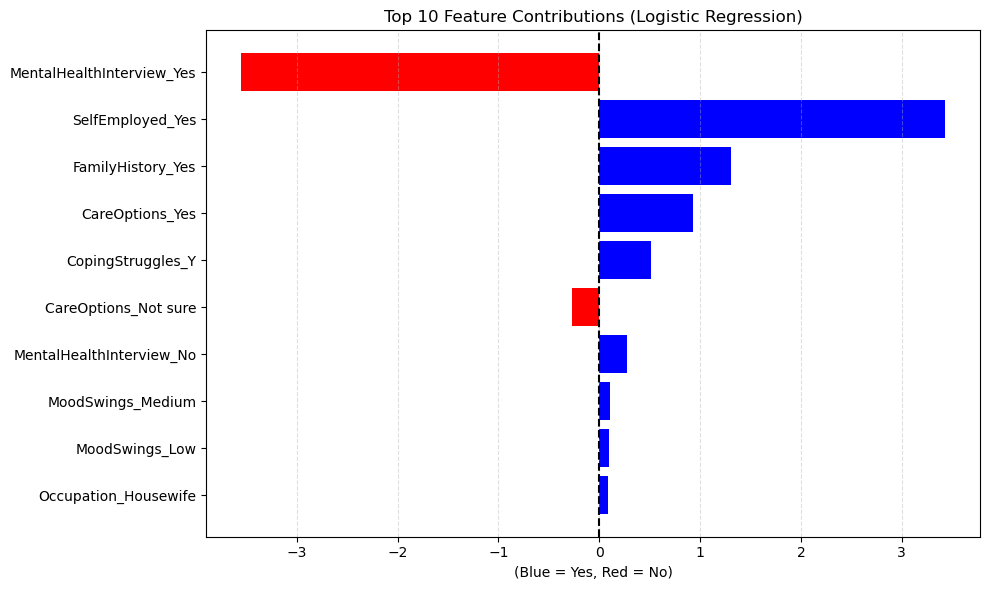

In [66]:
# TOP 10 FEATURE CONTRIBUTIONS

coef_df = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Coefficient": model.coef_[0]
})
coef_df["Abs"] = coef_df["Coefficient"].abs()

top10 = coef_df.sort_values("Abs", ascending=False).head(10)
top10["Color"] = top10["Coefficient"].apply(lambda x: "blue" if x > 0 else "red")

plt.figure(figsize=(10, 6))
plt.barh(top10["Feature"], top10["Coefficient"], color=top10["Color"])
plt.gca().invert_yaxis()
plt.axvline(0, linestyle="--", color="black")

plt.xlabel("(Blue = Yes, Red = No)")
plt.title("Top 10 Feature Contributions (Logistic Regression)")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [67]:
# ODDS RATIOS
coef_df["Odds_Ratio"] = np.exp(coef_df["Coefficient"])

odds_ratios_sorted = coef_df[["Feature", "Coefficient", "Odds_Ratio"]].sort_values(
    by="Odds_Ratio", ascending=False
)

print("\n--- Odds Ratios (Exp(Coefficient)) ---")
print(odds_ratios_sorted.to_string(index=False))


--- Odds Ratios (Exp(Coefficient)) ---
                       Feature  Coefficient  Odds_Ratio
              SelfEmployed_Yes     3.426826   30.778788
             FamilyHistory_Yes     1.301792    3.675877
               CareOptions_Yes     0.929041    2.532079
             CopingStruggles_Y     0.509386    1.664269
      MentalHealthInterview_No     0.273531    1.314598
             MoodSwings_Medium     0.107157    1.113109
                MoodSwings_Low     0.096840    1.101684
          Occupation_Housewife     0.088032    1.092023
  DaysIndoors_Go out Every day     0.047906    1.049072
            SocialWeakness_Yes     0.031850    1.032362
               WorkInterest_No     0.027250    1.027624
               HabitsChange_No     0.018604    1.018778
           CopingStruggles_Yes     0.017150    1.017298
             SocialWeakness_No     0.008347    1.008382
              HabitsChange_Yes     0.008176    1.008210
        DaysIndoors_31-60 days    -0.004425    0.995585
        

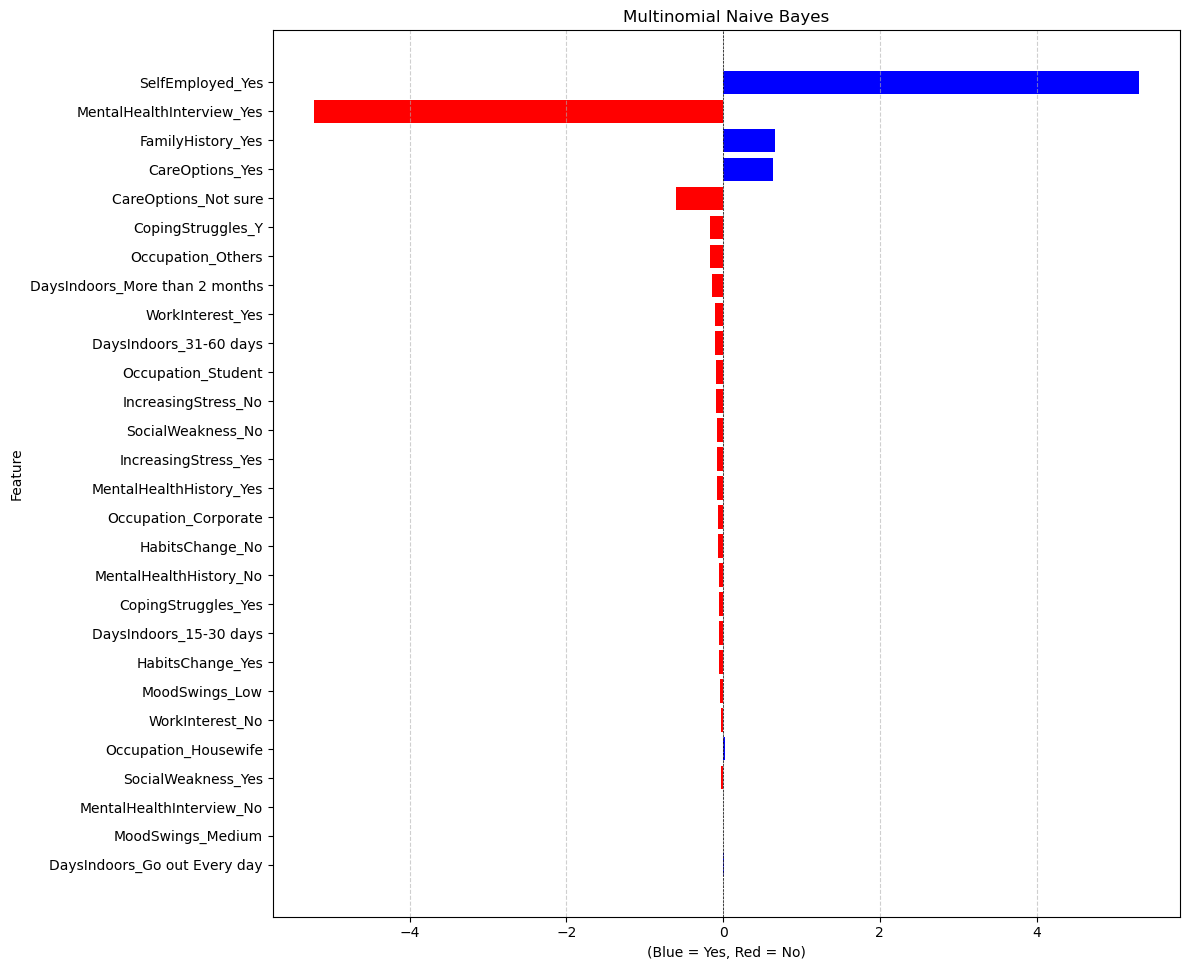

In [68]:

log_probs_no = mnb_model.feature_log_prob_[0, :]
log_probs_yes = mnb_model.feature_log_prob_[1, :]


#A positive value (Blue) means the feature strongly predicts 'Yes' (Treatment).
mnb_impact = log_probs_yes - log_probs_no

# 3. Create DataFrame and prepare for plotting
mnb_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Impact': mnb_impact
})

mnb_df['Abs_Impact'] = np.abs(mnb_df['Impact'])
mnb_df = mnb_df.sort_values(by='Abs_Impact', ascending=True)

# Define color based on sign
mnb_df['Color'] = mnb_df['Impact'].apply(lambda x: 'blue' if x >= 0 else 'red')

# 4. Plot the results
plt.figure(figsize=(12, len(mnb_df) * 0.35))
plt.barh(mnb_df['Feature'], mnb_df['Impact'], color=mnb_df['Color'])
plt.xlabel('(Blue = Yes, Red = No)')
plt.ylabel('Feature')
plt.title('Multinomial Naive Bayes')
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()